## Dataset4_nasdaq

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [6]:
df = pd.read_csv('Dataset4_yahoo304.96.8.14.csv', names = ["yahoo"])

In [7]:
df.head()

,yahoo
0,35.91
1,35.66
2,35.79
3,35.70
4,36.53


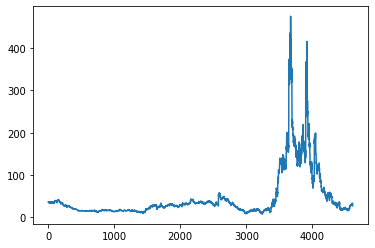

In [9]:
plt.plot(df['yahoo'])

**ADF Test**

In [11]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = df[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('yahoo')

Results of Dickey-Fuller Test for  yahoo 

Test Statistic                   -3.286733
p-value                           0.015482
#Lags Used                       30.000000
Number of Observations Used    4582.000000
Critical Value (1%)              -3.431778
Critical Value (5%)              -2.862171
Critical Value (10%)             -2.567106
dtype: float64


ADF test: The test statistic is less than the critical value, so we can reject the null hypothesis. So it is stationary series.
Also P value is less than 0.05 so, from that also we can say it is stationary. 

**KPSS Test**

In [13]:
def kpss_test(atr):
    timeseries = df[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('yahoo')

Results of KPSS Test for  yahoo
Test Statistic            3.701679
p-value                   0.010000
Lags Used                32.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


KPSS Test: The test statistic is greater than the critical value so we can reject the null hypothesis. So it is non-stationary series.


SO from both tests, we can say it is differential stationary series.

**Differencing with period 1 to make non-stationary data to stationary dataseries.**

In [15]:
df['Diff'] = df['yahoo'].diff(periods=1)

In [16]:
df

,yahoo,Diff
0,35.91,NaN
1,35.66,-0.25
2,35.79,0.13
3,35.70,-0.09
4,36.53,0.83
...,...,...
4608,29.25,0.38
4609,27.00,-2.25
4610,28.75,1.75
4611,32.25,3.50


In [17]:
adf_test('Diff')

Results of Dickey-Fuller Test for  Diff 

Test Statistic                -1.208386e+01
p-value                        2.200560e-22
#Lags Used                     3.200000e+01
Number of Observations Used    4.579000e+03
Critical Value (1%)           -3.431779e+00
Critical Value (5%)           -2.862171e+00
Critical Value (10%)          -2.567106e+00
dtype: float64


p value is less than the 0.05 so data is stationary.

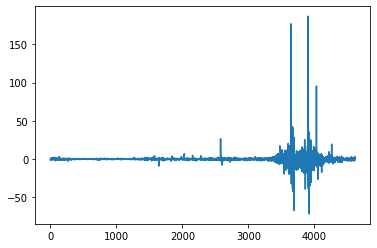

In [18]:
df['Diff'].plot()
plt.show()

In [19]:
data1 = df.iloc[:,0].values
dataset_array1 = [data1[0::1],data1[0::2],data1[0::4],data1[0::8],data1[0::12],data1[0::24]]

In [20]:
def plotting_function(MSE,MAE,name):
  interval = [1,2,3,4,5,6]

  barWidth = 0.25  
  r1 = np.arange(len(interval))
  r2 = [x + barWidth for x in r1]
  
  # Make the plot
  plt.bar(r1, MSE, color='b', width=barWidth, label='MSE')
  plt.bar(r2, MAE, color='g', width=barWidth, label='MAE')

  plt.xlabel('interval', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(interval))], ['1', '2', '4', '8', '12','24'])
  plt.title('MSE and MAE plot for '+(name))
  plt.legend()
  plt.show()
 

**single exponential smoothing**

In [22]:
def single_exp(data,interval,alpha):
  array1=data
  
  fv = np.array([None] * len(array1))
  for i in range(interval):
    fv[i]=array1[i]
   
  for i in range(interval, len(array1)):
    fv[i] = alpha * array1[i-interval] + (1 - alpha) * fv[i - interval]
  array = array1-fv
  arr = pd.DataFrame.from_dict({"yahoo":array1,"Forecasted value":fv,"Error":array})
  return arr

In [23]:
interval = [1,2,4,8,12,24]
mse1=[]
mae1=[]
for i in interval:
  a = single_exp(df.iloc[:,0],i,0.9)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse1.append(round(mse_val,6))
  mae1.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse1)
print('MSE for each interval respectively \n',mae1)

MSE for each interval respectively 
 [34.803908, 72.657139, 144.964821, 278.795799, 393.186704, 800.041788]
MSE for each interval respectively 
 [1.644295, 2.357519, 3.476447, 5.107317, 6.420738, 9.984419]


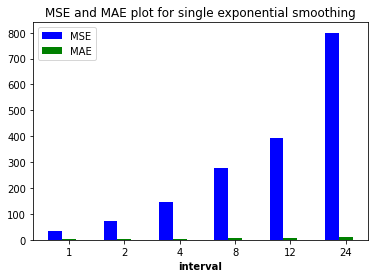

In [24]:
plotting_function(mse1,mae1,'single exponential smoothing')

**Double Exponential Smoothing**

In [25]:
def double_exp(data,interval,alpha,beta):
  array=data
  f = np.array([None] * len(array))
  a = np.array([None] * len(array))
  b = np.array([None] * len(array))
  

  f[0]=data[0]
  a[0] = array[0]
  b[0] = (array[(len(array)-1)] - array[0])/(len(array)-1)

  if interval<2:
    f[1] = a[0]+b[0]
    for i in range(2, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"yahoo":array,"Forecasted value":f,"Error":array-f})
  else:
    for i in range(2,interval):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]

    for i in range(1,interval):
      f[i] = a[i-1] + b[i-1]

    for i in range(interval, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"yahoo":array,"Forecasted value":f,"Error":array-f})
  return arr

In [26]:
interval = [1,2,4,8,12,24]
mse2=[]
mae2=[]
for i in interval:
  a = double_exp(df.iloc[:,0],i,0.9,0.01)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse2.append(round(mse_val,6))
  mae2.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse2)
print('MSE for each interval respectively \n',mae2)

MSE for each interval respectively 
 [35.05401, 35.061613, 35.076827, 35.107295, 35.137817, 35.229701]
MSE for each interval respectively 
 [1.647777, 1.648134, 1.64885, 1.650282, 1.651717, 1.656036]


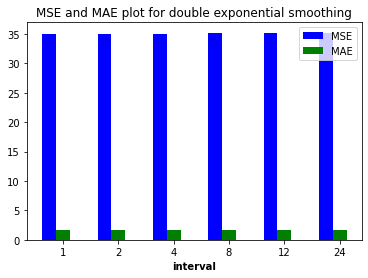

In [27]:
plotting_function(mse2,mae2,'double exponential smoothing')

**Triple Exponential Smoothing**

In [28]:
def initial_trend(data, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(data[i+season_len] - data[i]) / season_len
    return sum / season_len

def initial_seasonal(data, season_len):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(data)/season_len)
  # compute season averages
  for j in range(n_seasons):
    avg = ((data[(season_len*j):(season_len*j)+season_len]).sum())/float(season_len)
    season_averages.append(avg)
  # initial values
  for i in range(season_len):
    sum = 0.0
    for j in range(n_seasons):
      sum += data[season_len*j+i]-season_averages[j]
    seasonals[i] = sum/n_seasons
  return seasonals

def triple_exp(data, season_len, alpha, beta, gamma, n_preds):
  result = []
  error = []
  seasonals = initial_seasonal(data, season_len)
  for i in range(len(data)+n_preds):
    if i == 0: # initial values
      smooth = data[0]
      trend = initial_trend(data, season_len)
      result.append(data[0])
      continue
    if i >= len(data): # we are forecasting
      m = i - len(data) + 1
      result.append((smooth + m*trend) + seasonals[i%season_len])
    else:
      val = data[i]
      last_smooth, smooth = smooth, alpha*(val-seasonals[i%season_len]) + (1-alpha)*(smooth+trend)
      trend = beta * (smooth-last_smooth) + (1-beta)*trend
      seasonals[i%season_len] = gamma*(val-smooth) + (1-gamma)*seasonals[i%season_len]
      forecast = smooth+trend+seasonals[i%season_len]
      error = data - forecast
      result.append(forecast)
      
  SE = np.square(error)
  SSE = 0
  for i in SE:
    SSE+= i
  mse_val = SSE/(len(data)-1)
  mae_val = np.sum(abs(error)/len(error))
  return mse_val,mae_val

In [29]:
mse3 = []
mae3 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val = triple_exp(dataframe,1,0.9,0.02,0.95,1)
  mse3.append(round(mse_val,6))
  mae3.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse3)
print('MSE for each interval respectively \n',mae3)

MSE for each interval respectively 
 [3552.580348, 3543.295624, 3523.204961, 3735.714043, 3565.366598, 3906.277824]
MSE for each interval respectively 
 [28.984869, 28.948945, 28.810303, 28.239777, 27.888529, 28.517306]


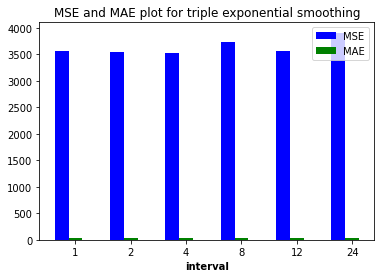

In [30]:
plotting_function(mse3,mae3,'triple exponential smoothing')

**ACF PACF Plot**

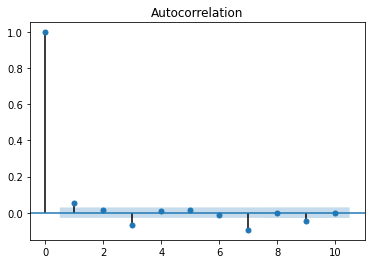

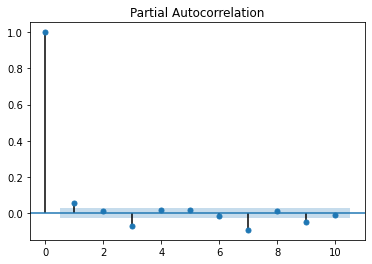

In [31]:
plot_acf(df.iloc[:,1].dropna(), lags=10)
plt.show()
plot_pacf(df.iloc[:,1].dropna(), lags=10)
plt.show()

pmdarima package install

In [1]:
!pip3 install pmdarima

     |████████████████████████████████| 1.5MB 6.8MB/s 
     |████████████████████████████████| 9.5MB 34.3MB/s 
     |████████████████████████████████| 2.1MB 36.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [32]:
import pmdarima as pm
model = pm.auto_arima(df.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=5, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, 
                      trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29358.877, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52832.194, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=46916.004, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29360.811, Time=0.73 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=29357.882, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=42222.823, Time=2.78 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=29345.809, Time=2.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=29290.882, Time=4.44 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=29348.048, Time=1.95 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=29298.511, Time=3.84 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=29296.227, Time=4.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=29340.140, Time=1.19 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=29340.710, Time=1.20 sec
 ARIMA(4,0,3)(0,0,0)[0]  

**AR model**

In [33]:
from statsmodels.tsa.arima_model import ARIMA
def ar_model(data):
  model=ARIMA(data,order=(3,0,0)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [34]:
mse4 = []
mae4 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ar_model(dataframe)
  mse4.append(round(mse_val,6))
  mae4.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse4)
print('MSE for each interval respectively \n',mae4)

MSE for each interval respectively 
 [33.891316, 66.843616, 131.952269, 269.411971, 321.422517, 736.109907]
MSE for each interval respectively 
 [1.631458, 2.352141, 3.517077, 5.128436, 6.037979, 10.267325]


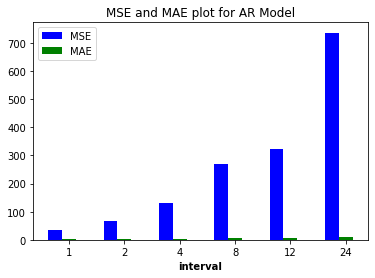

In [35]:
plotting_function(mse4,mae4,'AR Model')

**MA Model**

In [38]:
def ma_model(data):
  model=ARIMA(data,order=(0,0,1)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [39]:
mse5 = []
mae5 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ma_model(dataframe)
  mse5.append(round(mse_val,6))
  mae5.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse5)
print('MSE for each interval respectively \n',mae5)

MSE for each interval respectively 
 [967.860348, 1022.814595, 1050.152419, 1229.579787, 1227.452797, 1408.777788]
MSE for each interval respectively 
 [18.452403, 18.830714, 18.760088, 19.604586, 19.721267, 20.764311]


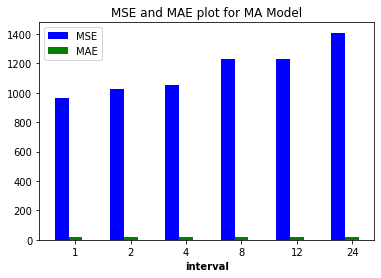

In [40]:
plotting_function(mse5,mae5,'MA Model')

**ARIMA Model**

In [45]:
def arima_model(data):
  model=ARIMA(data,order=(3,1,1)).fit()
  prediction = model.fittedvalues
  data = np.delete(data,[0])
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [46]:
mse6 = []
mae6 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = arima_model(dataframe)
  mse6.append(round(mse_val,6))
  mae6.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse6)
print('MSE for each interval respectively \n',mae6)

MSE for each interval respectively 
 [5512.115779, 5505.175013, 5462.983116, 5690.096, 5501.030922, 6076.652971]
MSE for each interval respectively 
 [46.140924, 46.115317, 46.056424, 46.204468, 45.920331, 46.613547]


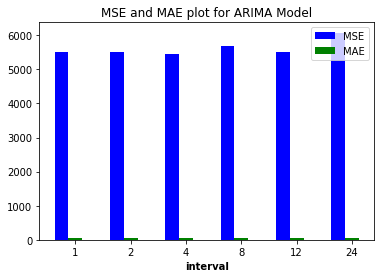

In [47]:
plotting_function(mse6,mae6,'ARIMA Model')